# generals

In [1]:
# general libraries
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import time
import requests
import json
import io

# analysis libraries
from sklearn.metrics import silhouette_score, davies_bouldin_score
from permetrics import ClusteringMetric
from scipy.spatial.distance import pdist
from paretoset import paretoset

import networkx as nx
from networkx.algorithms.community import louvain_communities

# visualization libraries
import plotly.express as px
from IPython.display import display, Markdown
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
import seaborn as sns
import matplotlib.colors as colors
from PIL import Image

In [2]:
import plotly.io as pio
pio.renderers.default = 'notebook_connected'

In [3]:
# directories
datasets_dir = "../../datasets/"

# datasets

In [4]:
# OSM data: we need to fix the coordinate reference system
data = gpd.read_file(datasets_dir + "geopoints_data.geojson")
data['lat_m'] = data.geometry.x
data['lon_m'] = data.geometry.y
data['node_id'] = data['node_id'].astype('string')

# RASTER DATA:
polygons = gpd.read_file(datasets_dir + "bologna_polygons.geojson")
polygons = polygons.to_crs('EPSG:32632')
polygons['id'] = polygons['id'].astype(str)

print("all datasets loaded")

all datasets loaded


In [5]:
polygons

,id,geometry
0,0,"POLYGON ((687085.679 4923677.699, 687040.585 4..."
1,1,"POLYGON ((691796.116 4928098.449, 691795.118 4..."
2,2,"POLYGON ((692735.175 4932802.702, 692714.316 4..."
3,3,"POLYGON ((678169.561 4930026.696, 678146.279 4..."
4,4,"POLYGON ((682122.038 4928729.725, 682088.36 49..."
5,5,"POLYGON ((687410.49 4929471.999, 687362.019 49..."
6,6,"POLYGON ((687362.019 4929910.751, 687410.49 49..."
7,7,"POLYGON ((686446.886 4930622.137, 686361.781 4..."


# functions setting

In [6]:
threshold_parameter = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5]

resolution_parameter = [0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0, 2.2, 2.4]

In [7]:
def dist_matrix_extraction(setting, polygon):
    
    current_matrix = pd.read_csv("../../datasets/matrix_computation/" + setting + "/polygon" + str(polygon) + ".csv", index_col=0)
    current_matrix.columns = current_matrix.columns.astype(int)
    
    return current_matrix

In [8]:
def compound_validity_index(dataset, matrix, graph):
    
    # preparation
    labels = dataset['clusters'].values
    
    ### ---

    # 0) Outlier ratio
    noise_ratio = np.sum(labels == -1) / len(labels)
    noise_norm = 1 - noise_ratio  # NORMALIZATION

    ### ---
    
    # 1) Modularity
    communities = [set(dataset[dataset['clusters'] == c]['node_id'].astype(int)) 
                   for c in dataset['clusters'].unique()]
    mod_score = nx.algorithms.community.quality.modularity(graph, communities, weight='weight')
    mod_norm = (mod_score - 0) / (1 - 0)  # NORMALIZATION
    
    ### ---
    
    # preparation: now we don't need the noise data anymore
    clustered_data = dataset[dataset['clusters'] != -1].copy()
    clustered_labels = clustered_data['clusters'].values
    clustered_ids = clustered_data['node_id'].values.astype(int)
    
    # 2) Silouhette score -> check the compactness of results: how much clusters are densely distributed and well separated from each other
    submatrix = matrix.loc[clustered_ids, clustered_ids].to_numpy()
    sil_score = silhouette_score(submatrix, clustered_labels, metric='precomputed')
    sil_norm = (sil_score + 1) / 2 # NORMALIZATION
    
    ### ---
    
    # 3) Inter-centroid distance -> measures for separation between clusters
    centroids = clustered_data.groupby('clusters')[['lat_m', 'lon_m']].mean().values
    if len(centroids) > 1:
        centroid_dists = pdist(centroids) # computation in meters
        sep_score = centroid_dists.mean()
        sep_norm = sep_score / (matrix.loc[clustered_ids, clustered_ids].values.max()*1000) # turn it to meters + NORMALIZATION
    else:
        sep_score, sep_norm = np.nan, np.nan
        
    ### ---
    
    # compound validity score
    cvs = np.mean([noise_norm, mod_norm, sil_norm, sep_norm])
    res = [round(noise_norm, 2), round(mod_norm, 2), round(sil_norm, 2), round(sep_norm, 2), round(cvs, 2)]
    
    return res
    

In [9]:
def graph_construction(matrix, max_dist):
    
    similarity = 1 / (1 + matrix)
    ids = [int(el) for el in matrix.index]
    G = nx.Graph()
    G.add_nodes_from(ids)
    
    n = len(ids)
    
    for i in range(n):
        for j in range(i + 1, n):
            distance = matrix.iloc[i, j]
            if distance <= max_dist:  
                weight = similarity.iloc[i, j] 
                G.add_edge(ids[i], ids[j], weight=weight)
    return G

In [10]:
def louvain_clustering(G, matrix, dataset, grid, setting, max_dist, resolution):
    
    # initialize algorithm
    communities = louvain_communities(G, 
                                      weight='weight', 
                                      resolution=resolution,
                                      seed=42) # setting seed to guarantee reproducibilty of results

    # create correspondance between the data
    node_to_community = {}
    
    for cid, community_nodes in enumerate(communities):
        for node in community_nodes:
            node_to_community[node] = cid
    
    #print(node_to_community)
    ids = [int(el) for el in matrix.index]
    communities_df = pd.DataFrame({
        'id': ids,
        'clusters': [node_to_community[node] for node in ids]})
    
    communities_df['id'] = communities_df['id'].astype("string") 
    complete_subset = dataset.merge(communities_df, left_on='node_id',right_on="id", how='left') 

    # check for clusters composed of single nodes
    cluster_sizes = complete_subset['clusters'].value_counts()
    valid_clusters = cluster_sizes[cluster_sizes == 1].index
    complete_subset.loc[complete_subset['clusters'].isin(valid_clusters), 'clusters'] = -1 # reassign those values to -1 for comparison with noises
    
    clusters = complete_subset['clusters'].values # now all singletons are counted as a unique cluster
    num_clusters = len(set(clusters)) - (1 if -1 in clusters else 0)
    
    if num_clusters in range(2, dataset.shape[0]): # more than one cluster is identified 
        validation_metrics = compound_validity_index(complete_subset, matrix, G)
        
        # STORE THE RESULTS
        res = [grid, setting, max_dist, resolution, num_clusters] + validation_metrics
        
        return res
    else: 
        #print("no cluster identified")
        pass

# Louvain clustering

In [11]:
columns = ['polygon_id', 'buffer', 'dist', 'res', 'clusters', 
           'clus_score',
           'mod_score',
           'sil_score', 
           'icd_score', 
           'cvs']


## ORIGINAL DATA

In [12]:
# it may take a while
data_original = []

for polygon in data.polygon_id.unique():
    
    # retrieve subset of data points
    subset = data[data.polygon_id==polygon]
    
    # retrieve the corresponding distance matrix 
    matrix = dist_matrix_extraction("original", polygon)
    
    for thresh in threshold_parameter:
        graph = graph_construction(matrix, thresh)
        
        for i in resolution_parameter:
            
            # compute the clustering on street
            current_res = louvain_clustering(graph, matrix, subset, polygon, "original", thresh, i)
    
            if current_res is not None:
                data_original.append(current_res)

In [13]:
# turn into the results into dataframes
data_original = pd.DataFrame (data=data_original, columns=columns)

#check
data_original

,polygon_id,buffer,dist,res,clusters,clus_score,mod_score,sil_score,icd_score,cvs
0,6,original,0.1,0.4,22,0.34,0.94,0.90,0.36,0.64
1,6,original,0.1,0.6,22,0.34,0.94,0.90,0.36,0.64
2,6,original,0.1,0.8,22,0.34,0.94,0.90,0.36,0.64
3,6,original,0.1,1.0,22,0.34,0.94,0.90,0.36,0.64
4,6,original,0.1,1.2,22,0.34,0.94,0.90,0.36,0.64
...,...,...,...,...,...,...,...,...,...,...
1282,2,original,1.5,1.6,3,0.93,0.41,0.72,0.29,0.59
1283,2,original,1.5,1.8,4,0.93,0.33,0.70,0.31,0.57
1284,2,original,1.5,2.0,5,0.89,0.24,0.71,0.31,0.54
1285,2,original,1.5,2.2,6,0.89,0.21,0.71,0.32,0.53


## 100 M BUFFERED DATA

In [14]:
# it may take a while
data_buffer100 = []

for polygon in data.polygon_id.unique():
    
    # retrieve subset for street
    matrix = dist_matrix_extraction("buffer_100", polygon)
    
    # we can retrieve directly the ids of data points inside the buffered polygons from the matrix
    current_nodes = [str(el) for el in matrix.index]
    subset = data[data.node_id.isin(current_nodes)]
    
    for thresh in threshold_parameter:
        graph = graph_construction(matrix, thresh)
        
        for i in resolution_parameter:
            
            # compute the clustering on street
            current_res = louvain_clustering(graph, matrix, subset, polygon, "buffer_100", thresh, i)
    
            if current_res is not None:
                data_buffer100.append(current_res)
    

In [15]:
# turn into the results into dataframes
data_buffer100 = pd.DataFrame (data=data_buffer100, columns=columns)
#check
data_buffer100

,polygon_id,buffer,dist,res,clusters,clus_score,mod_score,sil_score,icd_score,cvs
0,6,buffer_100,0.1,0.4,22,0.31,0.94,0.90,0.36,0.63
1,6,buffer_100,0.1,0.6,22,0.31,0.94,0.90,0.36,0.63
2,6,buffer_100,0.1,0.8,22,0.31,0.94,0.90,0.36,0.63
3,6,buffer_100,0.1,1.0,22,0.31,0.94,0.90,0.36,0.63
4,6,buffer_100,0.1,1.2,22,0.31,0.94,0.90,0.36,0.63
...,...,...,...,...,...,...,...,...,...,...
1288,2,buffer_100,1.5,1.6,3,0.94,0.40,0.70,0.25,0.57
1289,2,buffer_100,1.5,1.8,5,0.94,0.28,0.68,0.26,0.54
1290,2,buffer_100,1.5,2.0,5,0.94,0.28,0.66,0.25,0.53
1291,2,buffer_100,1.5,2.2,5,0.90,0.27,0.67,0.26,0.53


## 200 M BUFFER DATA

In [16]:
# it may take a while
data_buffer200 = []

for polygon in data.polygon_id.unique():
    
    # retrieve subset for street
    matrix = dist_matrix_extraction("buffer_200", polygon)
    
    # we can restrieve directly the ids of data points inside the buffered polygons from the matrix
    current_nodes = [str(el) for el in matrix.index]
    subset = data[data.node_id.isin(current_nodes)]
    
    for thresh in threshold_parameter:
        graph = graph_construction(matrix, thresh)
        
        for i in resolution_parameter:
            
            # compute the clustering on street
            current_res = louvain_clustering(graph, matrix, subset, polygon, "buffer_200", thresh, i)
    
            if current_res is not None:
                data_buffer200.append(current_res)
    

In [17]:
# turn into the results into dataframes
data_buffer200 = pd.DataFrame (data=data_buffer200, columns=columns)

#check
data_buffer200

,polygon_id,buffer,dist,res,clusters,clus_score,mod_score,sil_score,icd_score,cvs
0,6,buffer_200,0.1,0.4,23,0.31,0.94,0.91,0.34,0.63
1,6,buffer_200,0.1,0.6,23,0.31,0.94,0.91,0.34,0.63
2,6,buffer_200,0.1,0.8,23,0.31,0.94,0.91,0.34,0.63
3,6,buffer_200,0.1,1.0,23,0.31,0.94,0.91,0.34,0.63
4,6,buffer_200,0.1,1.2,23,0.31,0.94,0.91,0.34,0.63
...,...,...,...,...,...,...,...,...,...,...
1310,2,buffer_200,1.5,1.6,3,0.94,0.40,0.70,0.25,0.57
1311,2,buffer_200,1.5,1.8,5,0.94,0.28,0.67,0.26,0.54
1312,2,buffer_200,1.5,2.0,5,0.94,0.28,0.66,0.25,0.53
1313,2,buffer_200,1.5,2.2,5,0.90,0.27,0.67,0.26,0.53


# result comparison

## Silhouette coefficient vs Cluster Ratio

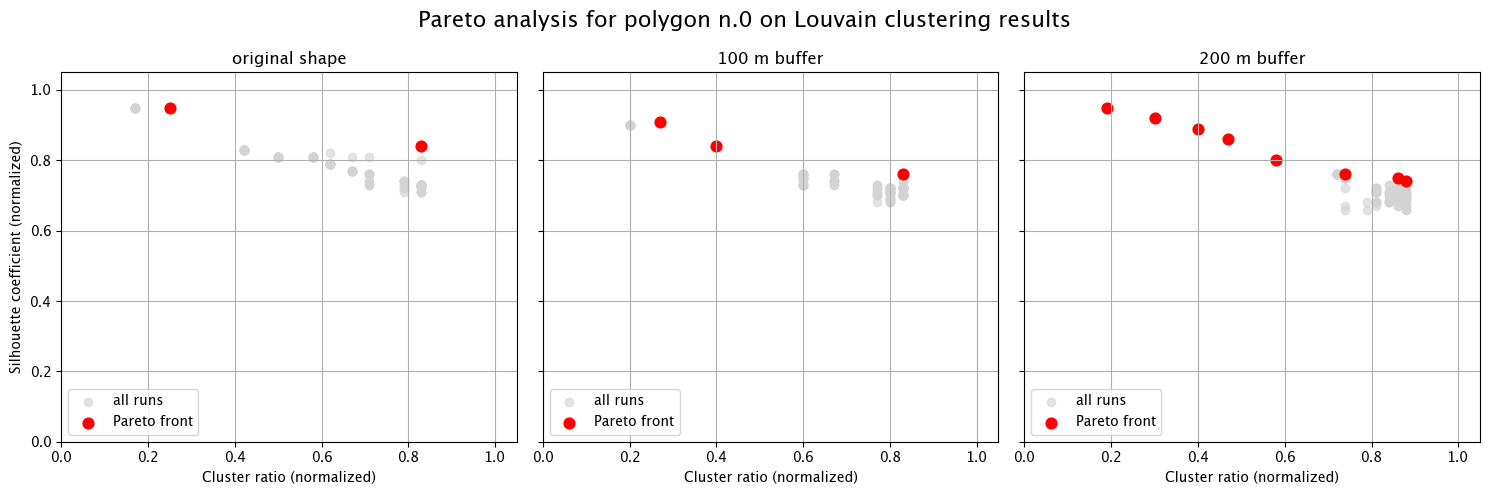

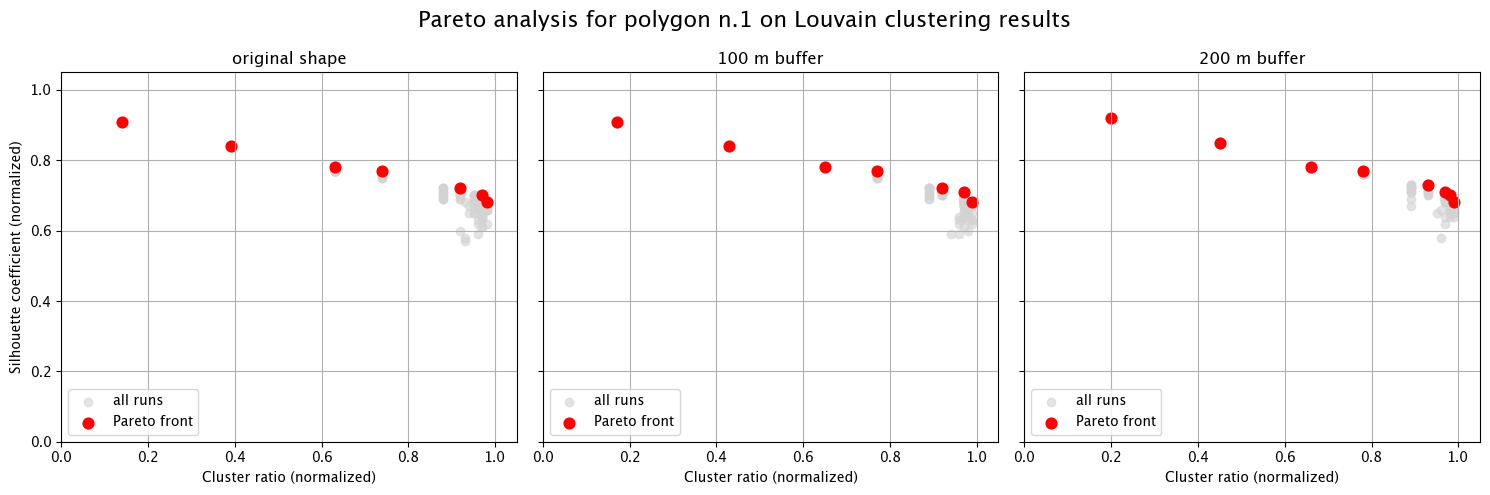

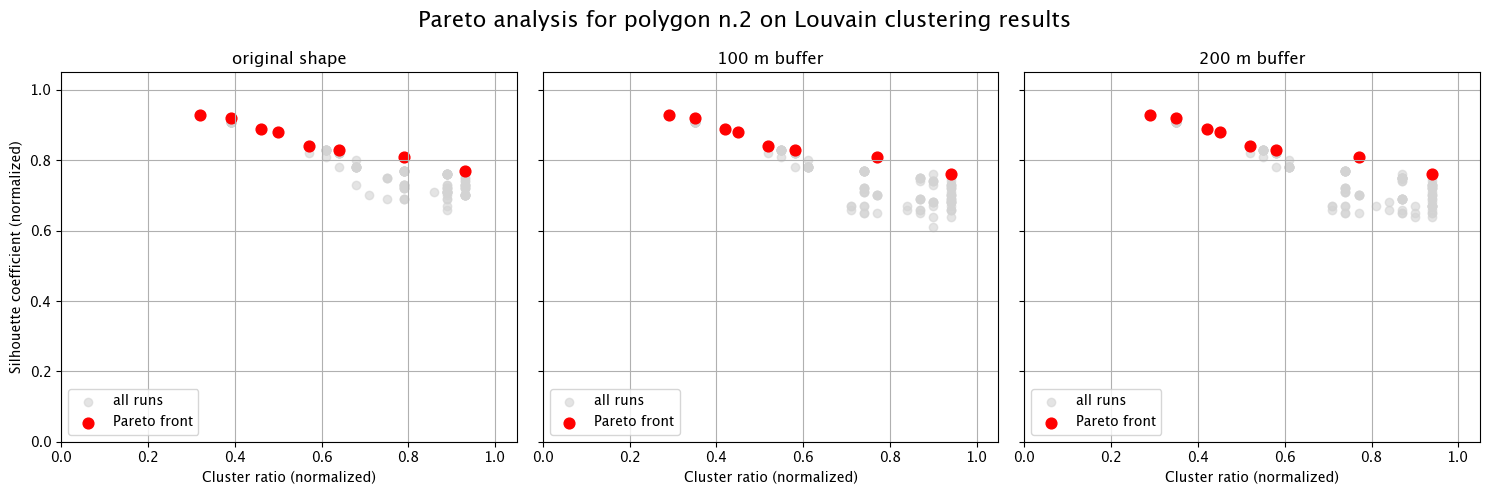

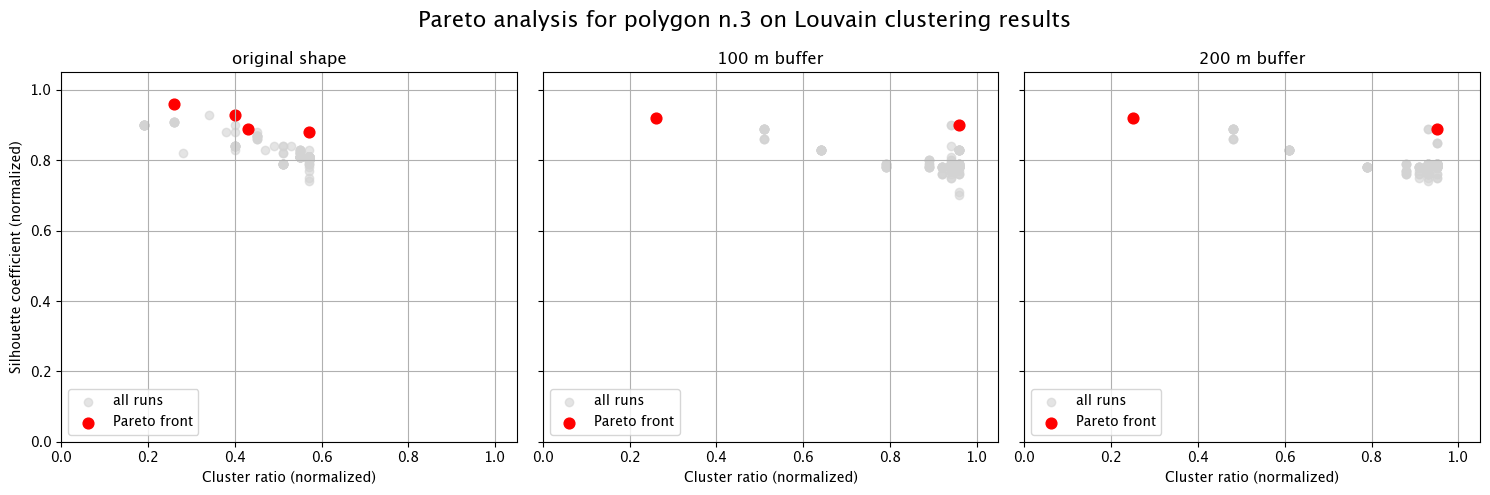

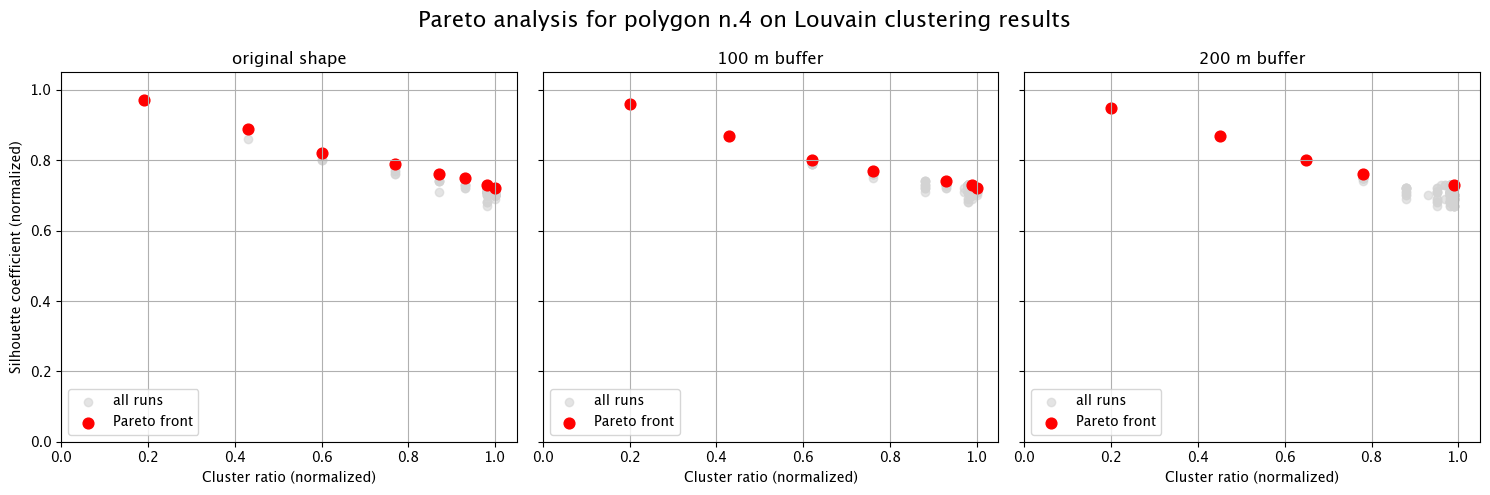

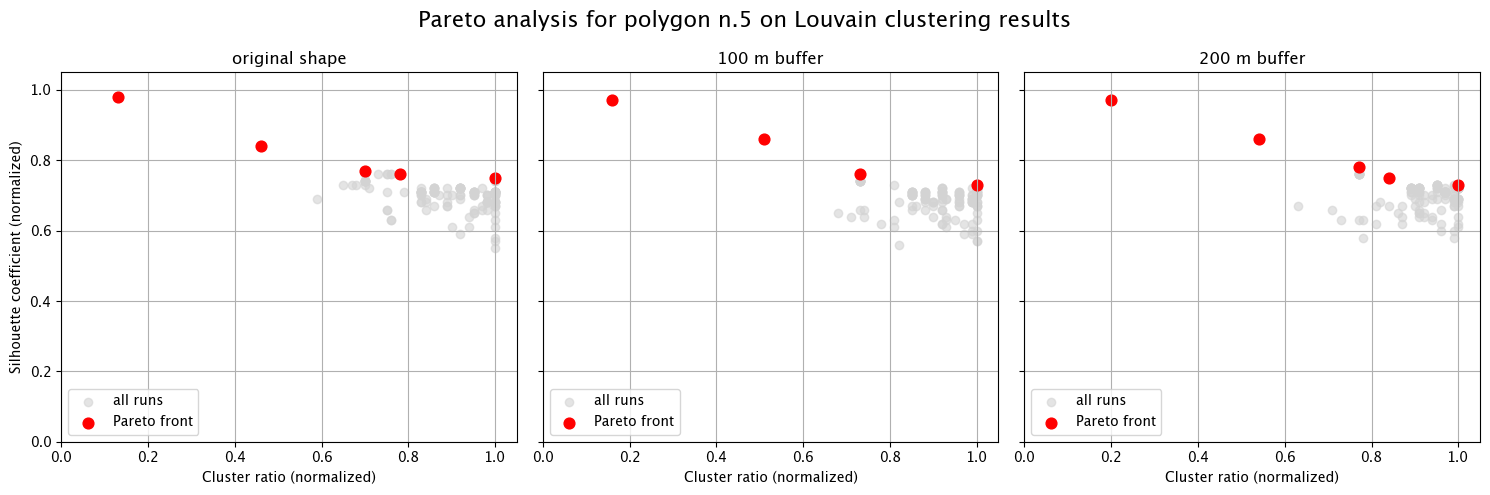

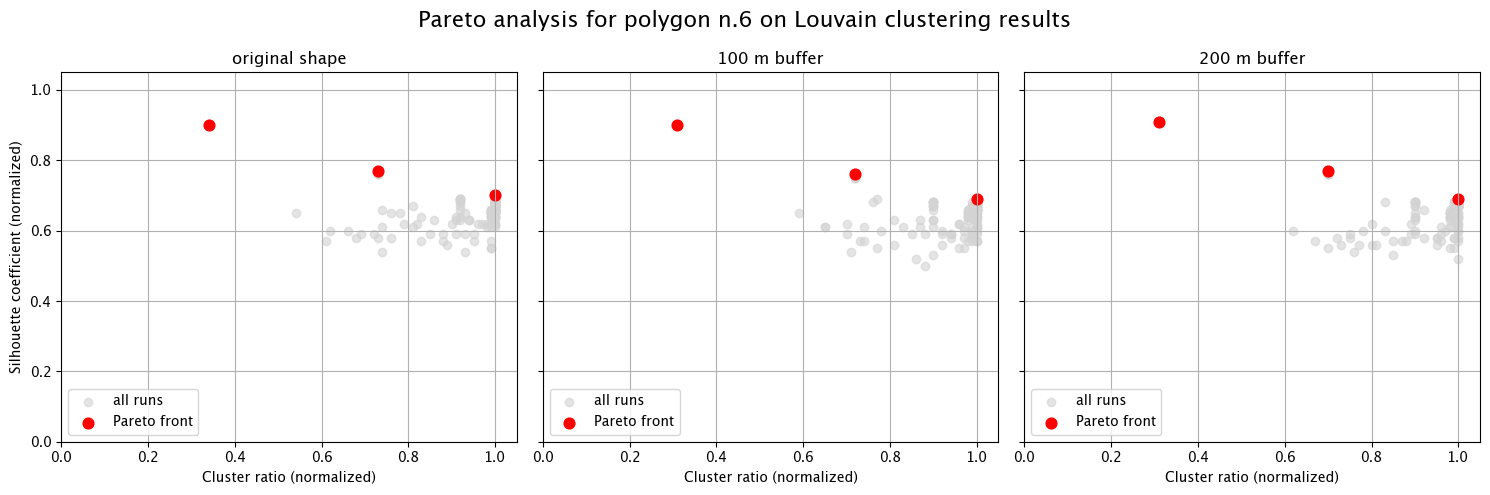

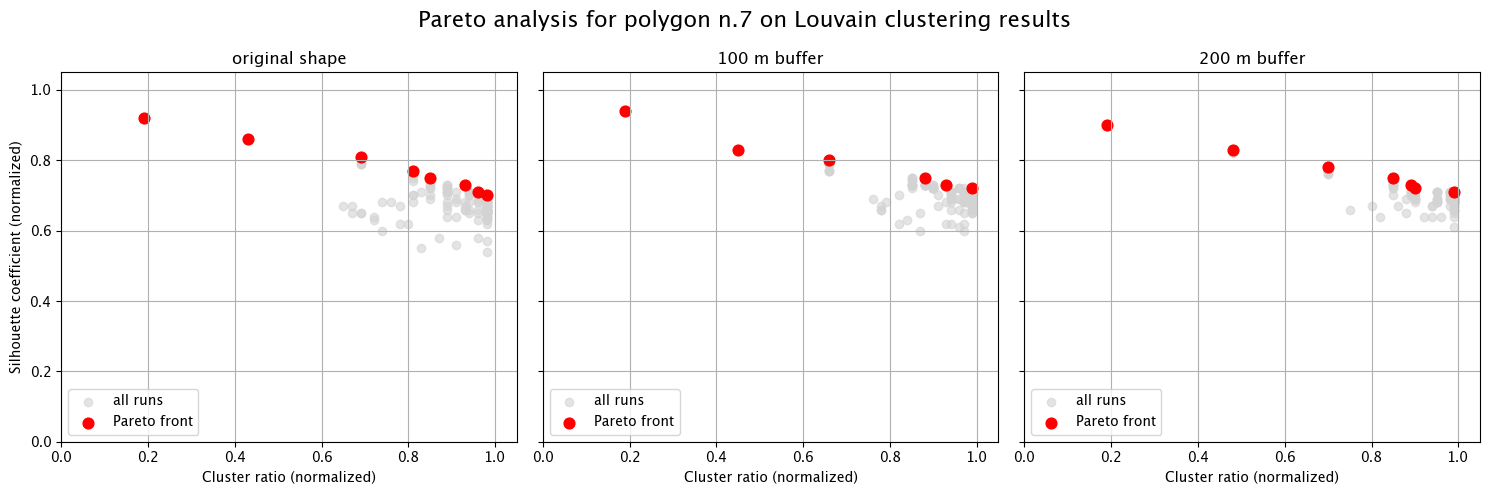

In [18]:
for pol in sorted(data.polygon_id.unique()):
    
    # Filter results for current polygon
    res_original = data_original[data_original['polygon_id'] == pol].copy()
    res_buffer100 = data_buffer100[data_buffer100['polygon_id'] == pol].copy()
    res_buffer200 = data_buffer200[data_buffer200['polygon_id'] == pol].copy()
    
    # Define objectives to maximize
    objectives = ['clus_score', 'sil_score']
    
    # Compute Pareto fronts separately
    pareto_mask_original = paretoset(res_original[objectives], sense=["max", "max"])
    pareto_mask_buffer100 = paretoset(res_buffer100[objectives], sense=["max", "max"])
    pareto_mask_buffer200 = paretoset(res_buffer200[objectives], sense=["max", "max"])
    
    # Keep Pareto-efficient points only
    res_original_pareto = res_original[pareto_mask_original]
    res_buffer100_pareto = res_buffer100[pareto_mask_buffer100]
    res_buffer200_pareto = res_buffer200[pareto_mask_buffer200]
    
    # --- Plot Pareto trade-offs (2D Silhouette vs DBI) ---
    fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
    
    datasets = [
        (res_original, res_original_pareto, "original shape", axes[0]),
        (res_buffer100, res_buffer100_pareto, "100 m buffer", axes[1]),
        (res_buffer200, res_buffer200_pareto, "200 m buffer", axes[2]),
    ]
    
    for full, pareto, title, ax in datasets:
        ax.scatter(full['clus_score'], full['sil_score'], color='lightgray', label='all runs', alpha=0.6)
        ax.scatter(pareto['clus_score'], pareto['sil_score'], color='red', label='Pareto front', s=60)
        ax.set_xlabel('Cluster ratio (normalized)')
        ax.set_xlim(0.0, 1.05)
        ax.set_ylim(0.0, 1.05)
        ax.legend(loc='lower left')
        ax.set_title(title)
        ax.grid(True)
    
    axes[0].set_ylabel('Silhouette coefficient (normalized)')
    fig.suptitle(f"Pareto analysis for polygon n.{pol} on Louvain clustering results", fontsize=16)
    
    plt.tight_layout()
    plt.show()

## Separation metric vs Silhouette score

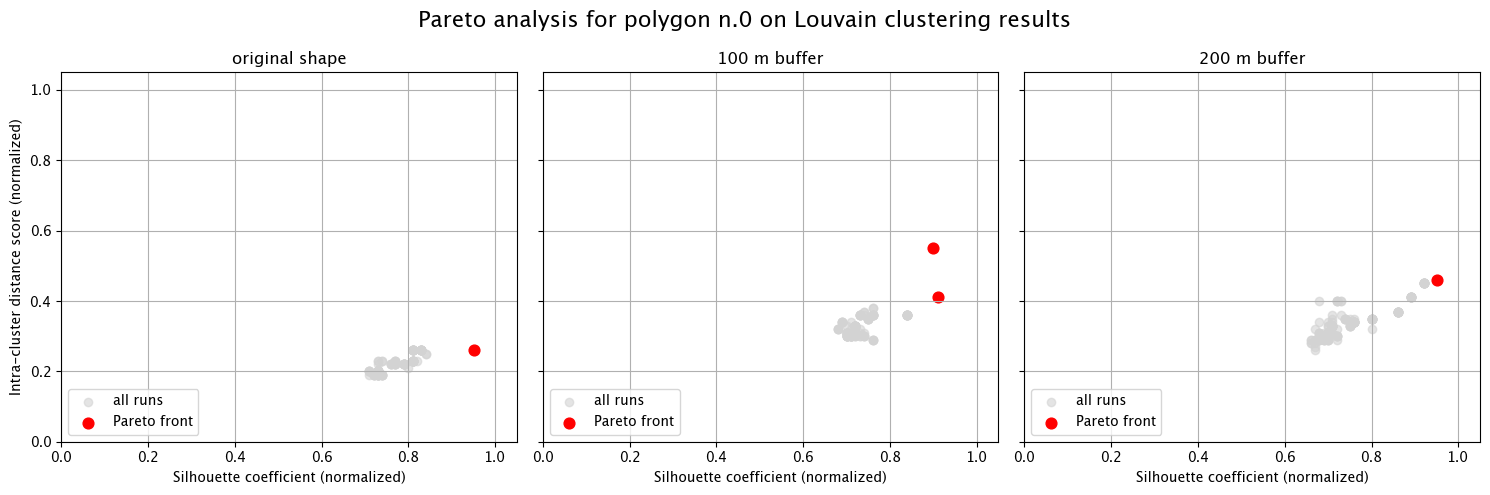

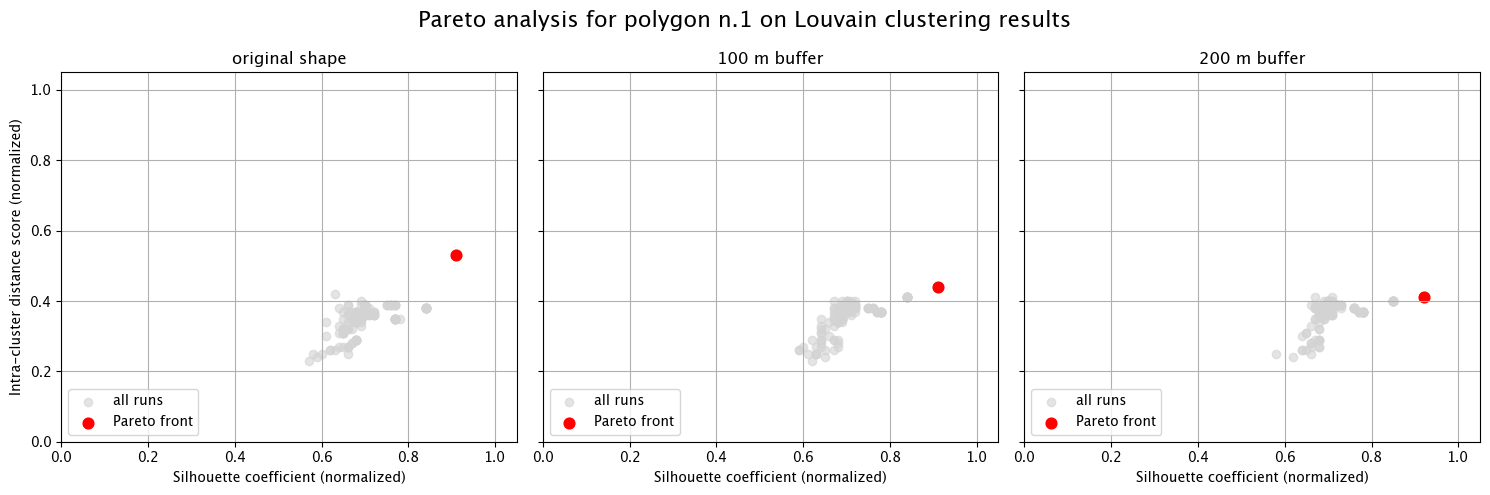

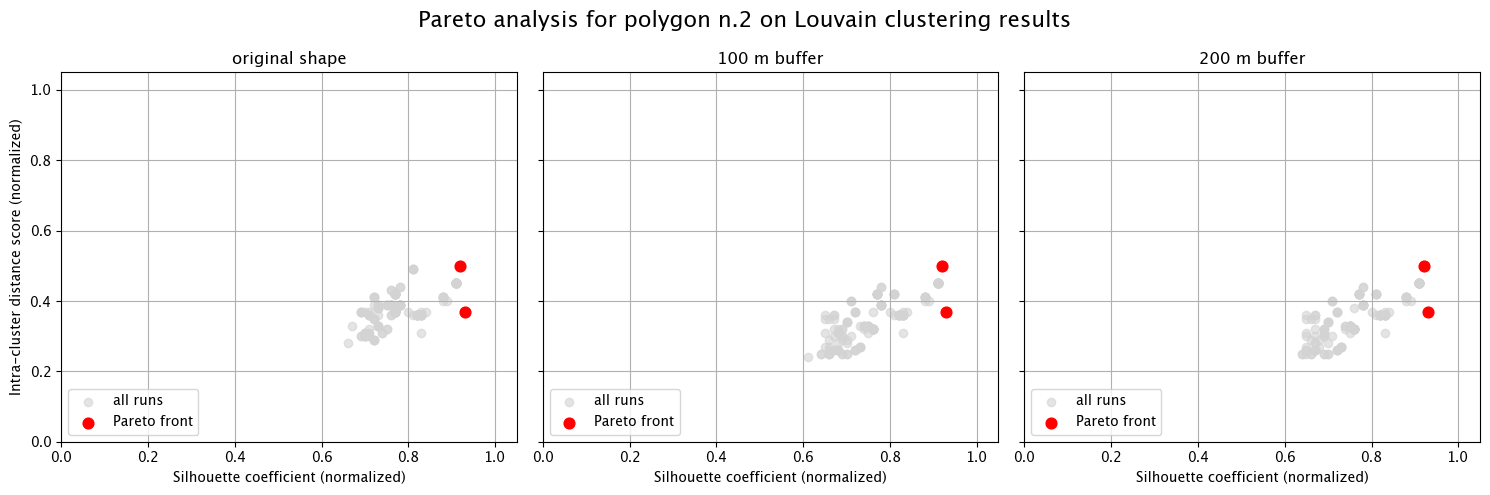

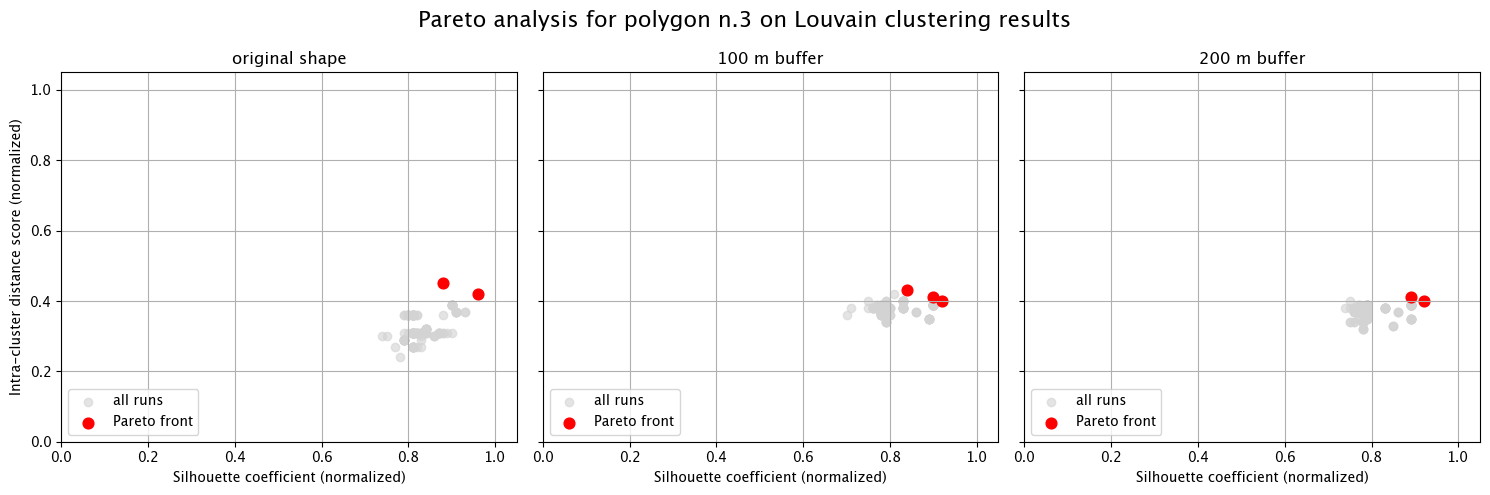

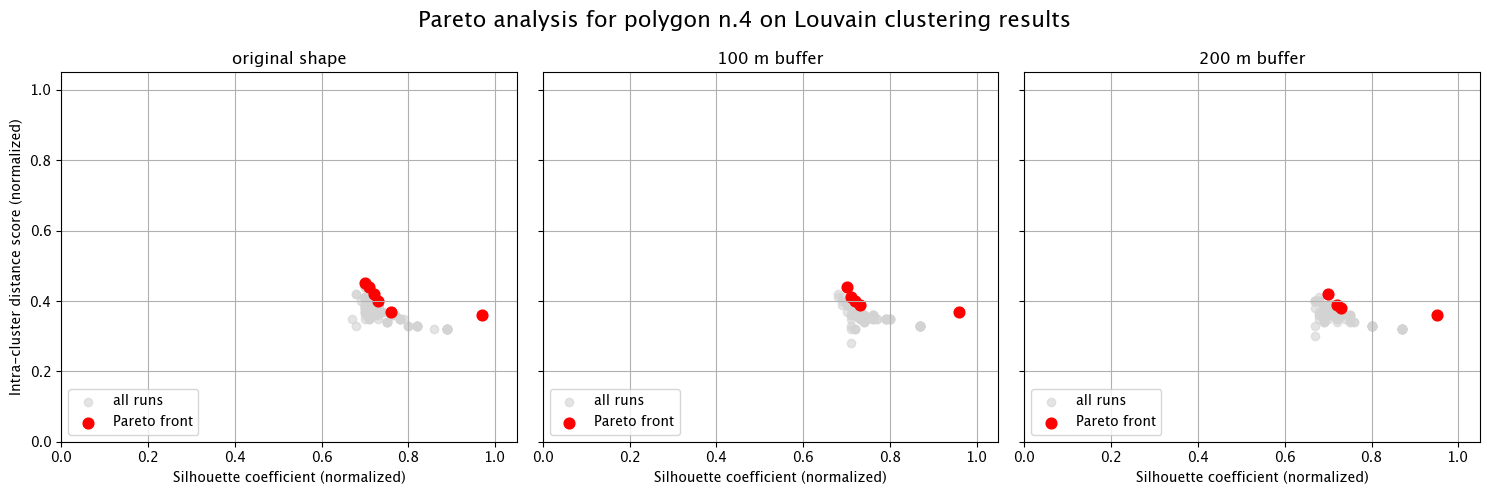

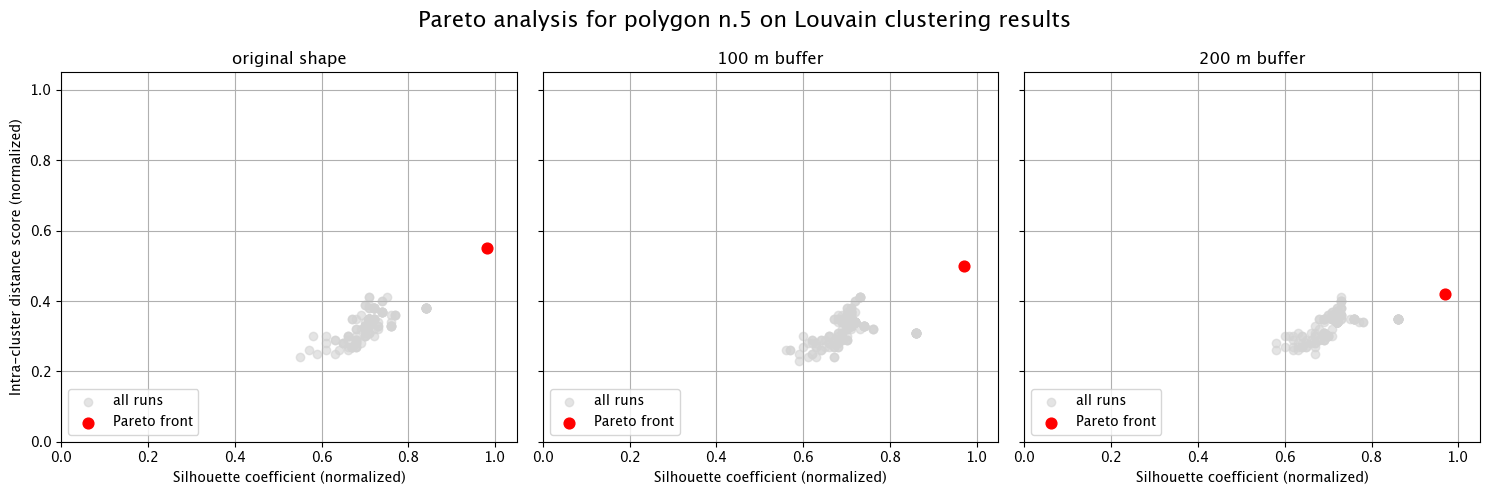

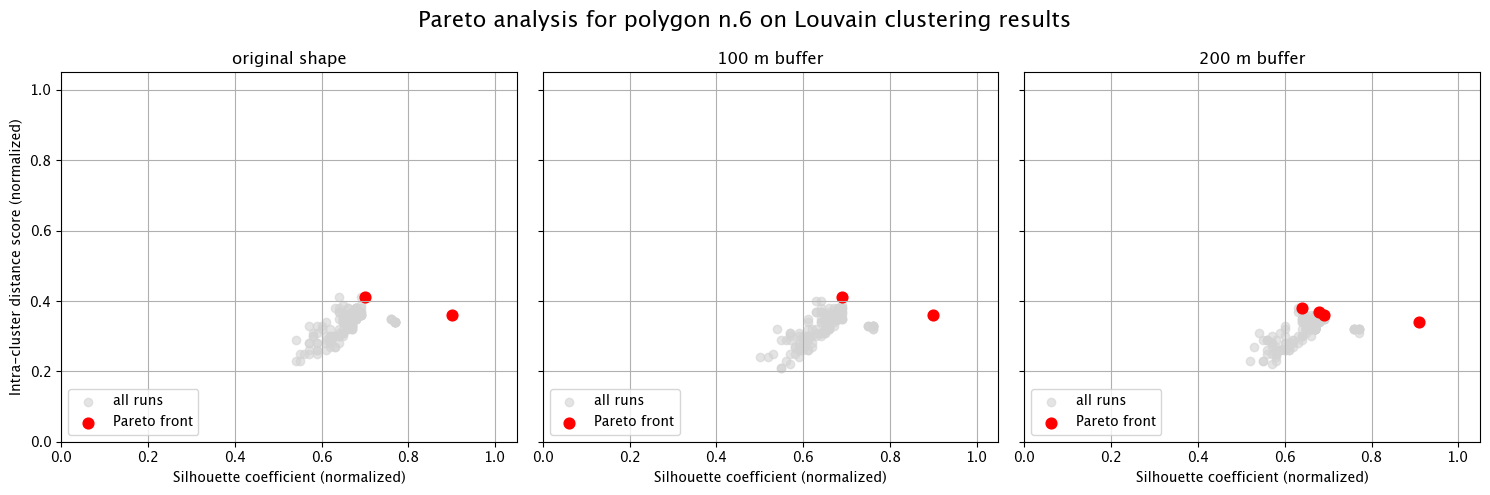

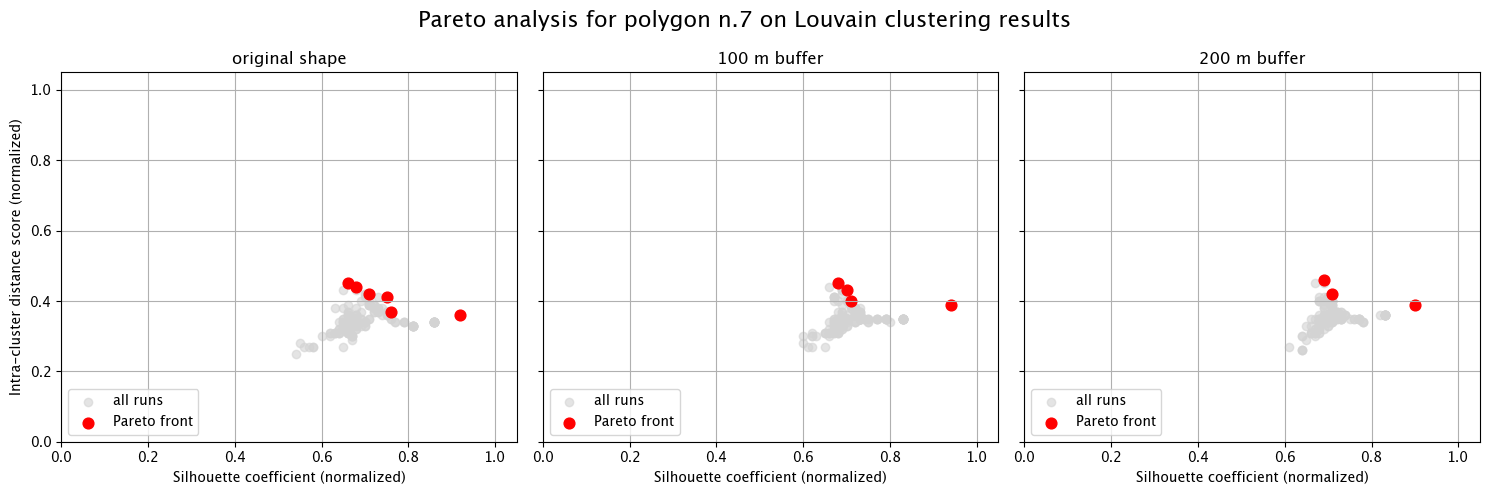

In [19]:
for pol in sorted(data.polygon_id.unique()):
    
    # Filter results for current polygon
    res_original = data_original[data_original['polygon_id'] == pol].copy()
    res_buffer100 = data_buffer100[data_buffer100['polygon_id'] == pol].copy()
    res_buffer200 = data_buffer200[data_buffer200['polygon_id'] == pol].copy()
    
    # Define objectives to maximize
    objectives = ['sil_score', 'icd_score']
    
    # Compute Pareto fronts separately
    pareto_mask_original = paretoset(res_original[objectives], sense=["max", "max"])
    pareto_mask_buffer100 = paretoset(res_buffer100[objectives], sense=["max", "max"])
    pareto_mask_buffer200 = paretoset(res_buffer200[objectives], sense=["max", "max"])
    
    # Keep Pareto-efficient points only
    res_original_pareto = res_original[pareto_mask_original]
    res_buffer100_pareto = res_buffer100[pareto_mask_buffer100]
    res_buffer200_pareto = res_buffer200[pareto_mask_buffer200]
    
    # --- Plot Pareto trade-offs (2D Silhouette vs DBI) ---
    fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
    
    datasets = [
        (res_original, res_original_pareto, "original shape", axes[0]),
        (res_buffer100, res_buffer100_pareto, "100 m buffer", axes[1]),
        (res_buffer200, res_buffer200_pareto, "200 m buffer", axes[2]),
    ]
    
    for full, pareto, title, ax in datasets:
        ax.scatter(full['sil_score'], full['icd_score'], color='lightgray', label='all runs', alpha=0.6)
        ax.scatter(pareto['sil_score'], pareto['icd_score'], color='red', label='Pareto front', s=60)
        ax.set_xlabel('Silhouette coefficient (normalized)')
        ax.set_xlim(0.0, 1.05)
        ax.set_ylim(0.0, 1.05)
        ax.legend(loc='lower left')
        ax.set_title(title)
        ax.grid(True)
    
    axes[0].set_ylabel('Inter-cluster distance score (normalized)')
    fig.suptitle(f"Pareto analysis for polygon n.{pol} on Louvain clustering results", fontsize=16)
    
    plt.tight_layout()
    plt.show()

## four-dimensional pareto analysis

In [20]:
pareto_general_results = []

for pol in sorted(data.polygon_id.unique()):
    
    # filtering based on the polygon
    res_original = data_original[data_original['polygon_id'] == pol].copy()
    res_buffer100 = data_buffer100[data_buffer100['polygon_id'] == pol].copy()
    res_buffer200 = data_buffer200[data_buffer200['polygon_id'] == pol].copy()
    
    objectives = ['sil_score', 'icd_score', 'mod_score', 'clus_score']
    
    # Pareto computation
    pareto_mask_original = paretoset(res_original[objectives], sense=["max", "max", "max", 'max'])
    pareto_mask_buffer100 = paretoset(res_buffer100[objectives], sense=["max", "max", "max", 'max'])
    pareto_mask_buffer200 = paretoset(res_buffer200[objectives], sense=["max", "max", "max", 'max'])
    
    # print see the results
    res_original_pareto = res_original[pareto_mask_original]
    res_buffer100_pareto = res_buffer100[pareto_mask_buffer100]
    res_buffer200_pareto = res_buffer200[pareto_mask_buffer200]
                                         
    # considering only the best ten results based on N (number of elements clustered)
    res_original_sorted = res_original_pareto.sort_values(by="cvs", ascending=False).head(10)
    res_buffer100_sorted = res_buffer100_pareto.sort_values(by="cvs", ascending=False).head(10)
    res_buffer200_sorted = res_buffer200_pareto.sort_values(by="cvs", ascending=False).head(10)
    
    
    # now we combine all the results obtained together
    best_results = pd.concat([res_original_sorted, res_buffer100_sorted, res_buffer200_sorted], ignore_index=True)
    
    # store them together                                    
    pareto_general_results.append(best_results)                                     
                                         
                                         
                                         
pareto_complete = pd.concat(pareto_general_results, ignore_index=True)  
                                         
# check
pareto_complete   

,polygon_id,buffer,dist,res,clusters,clus_score,mod_score,sil_score,icd_score,cvs
0,0,original,1.4,0.4,2,0.83,0.49,0.84,0.25,0.61
1,0,original,1.3,0.4,3,0.83,0.59,0.80,0.21,0.61
2,0,original,0.8,0.4,6,0.58,0.78,0.81,0.23,0.60
3,0,original,1.3,0.6,4,0.83,0.63,0.73,0.20,0.60
4,0,original,1.2,0.6,5,0.79,0.65,0.74,0.19,0.59
...,...,...,...,...,...,...,...,...,...,...
235,7,buffer_200,0.5,1.6,12,0.89,0.70,0.71,0.36,0.67
236,7,buffer_200,0.9,0.4,5,0.99,0.57,0.70,0.41,0.67
237,7,buffer_200,0.9,1.0,5,0.99,0.58,0.71,0.40,0.67
238,7,buffer_200,0.5,0.4,9,0.89,0.69,0.73,0.37,0.67


In [21]:
# store the results for following computations
result_path = os.path.join(datasets_dir, "pareto_louvain.csv")
pareto_complete.to_csv(result_path)

print(f"dataset stored in directory: {result_path}")

dataset stored in directory: datasets/pareto_louvain.csv


### heatmap plot

In [22]:
def cleanup_format(x):
    
    return f"{x:.2f}"


In [23]:
def plot_heatmap_with_pareto(ax, pivot, annots, title, pareto_df):
    sns.heatmap(pivot, 
                    ax=ax, 
                    cmap='Greens', 
                    annot=annots, 
                    annot_kws={"size": 7},
                    fmt="", 
                    cbar=False,
                    vmin=vmin, vmax=vmax)
    ax.set_title(title)
    ax.set_xlabel("maximum distance")
    ax.tick_params(axis='x', rotation=90)
    ax.invert_yaxis()

    # circle pareto points that exist in this pivot
    for _, p in pareto_df.iterrows():
        dist = p['dist']
        res = p['res']
        # check that (eps, el) exists in pivot table
        if dist in pivot.columns and res in pivot.index and not pd.isna(pivot.loc[res, dist]):
            x = list(pivot.columns).index(dist)
            y = list(pivot.index).index(res)
            circle = mpatches.Circle((x + 0.5, y + 0.5), radius=0.45, fill=False, edgecolor='red', linewidth=1)
            ax.add_patch(circle)

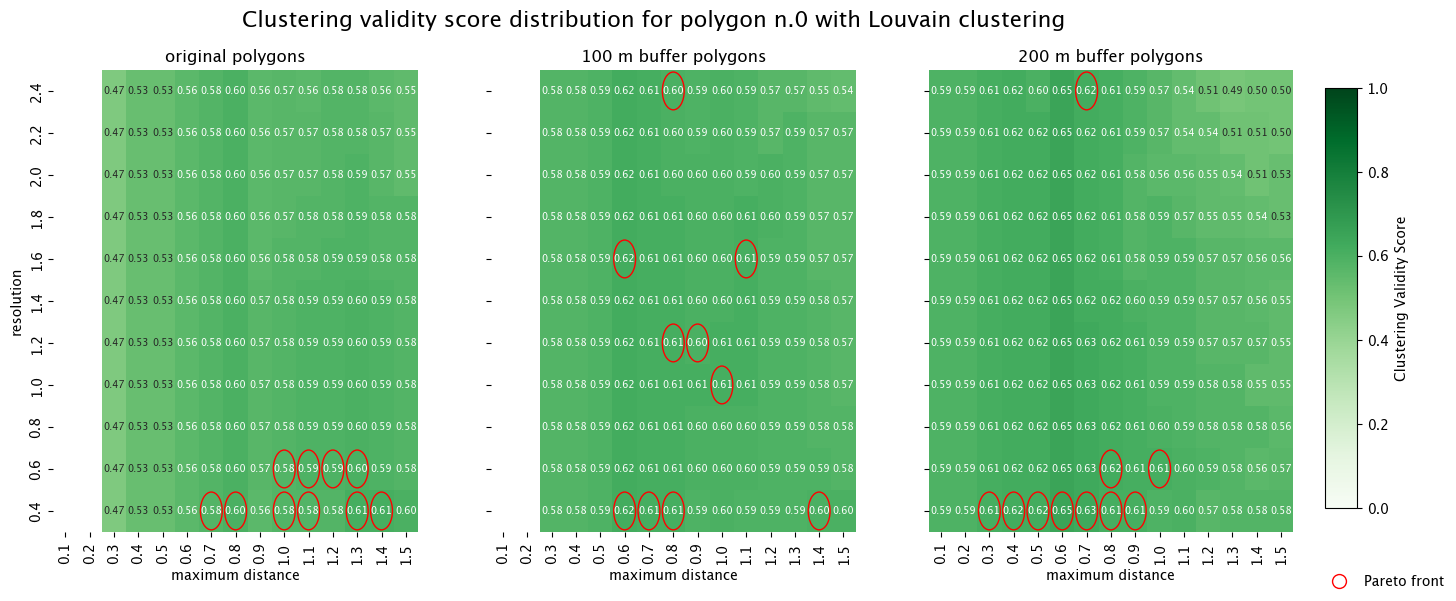

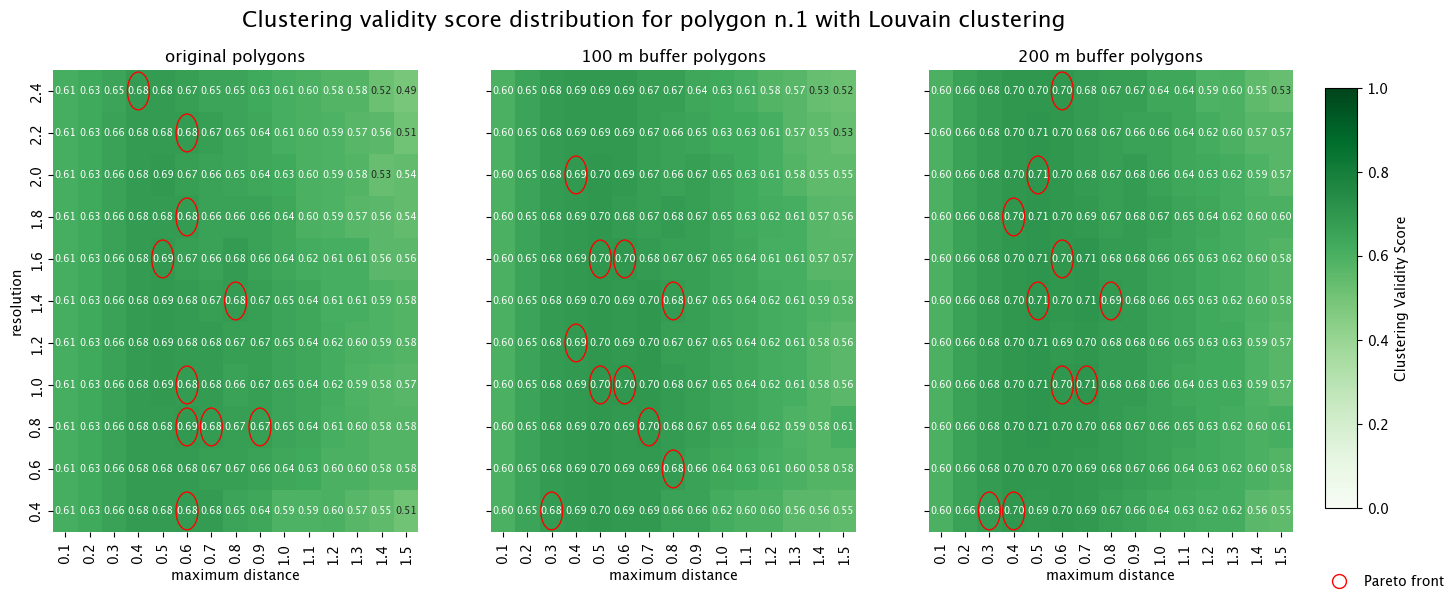

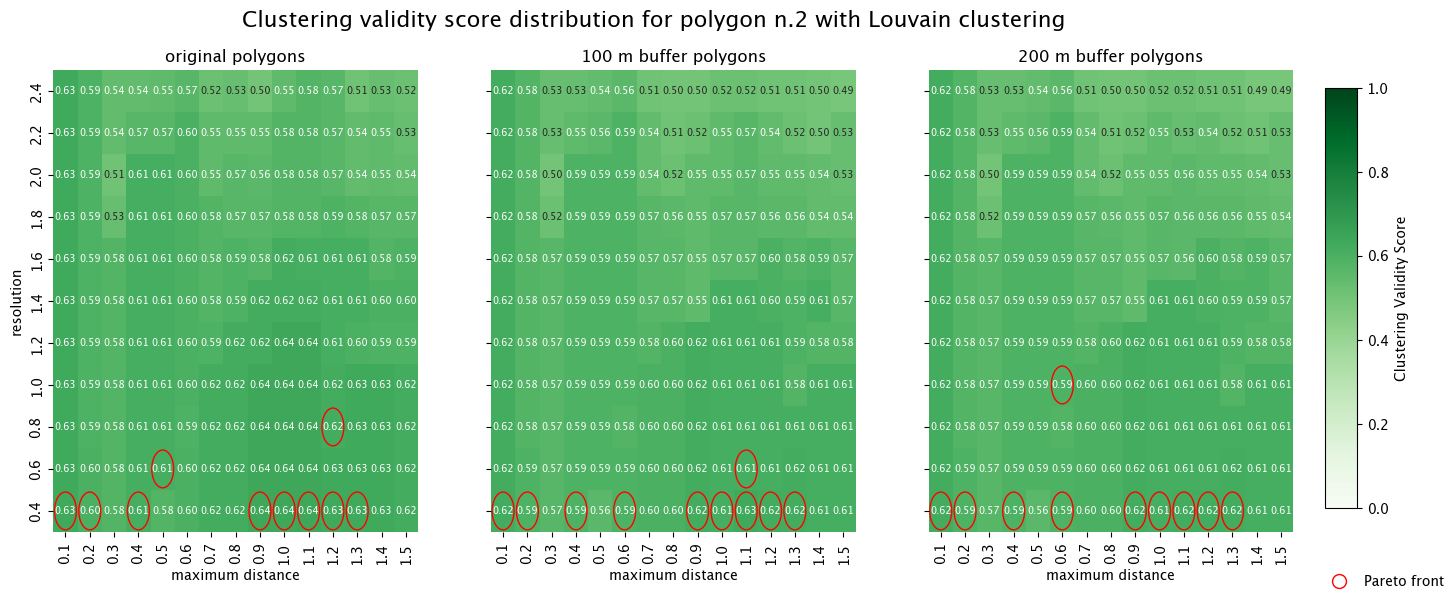

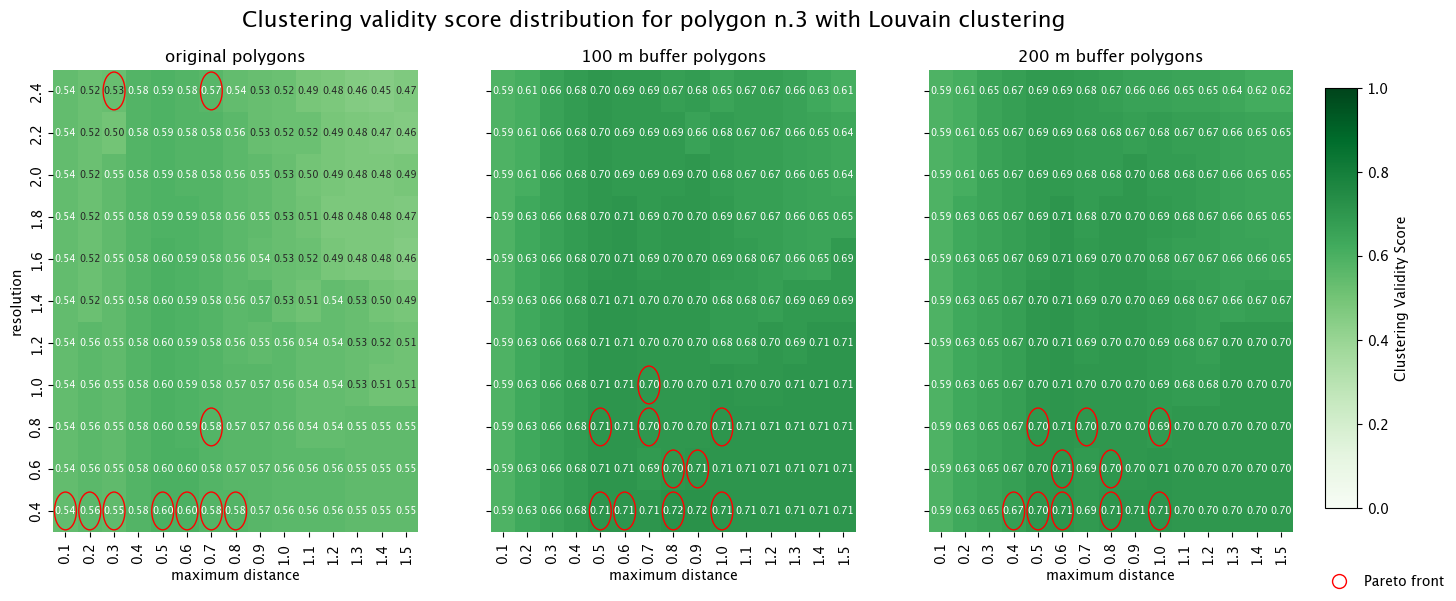

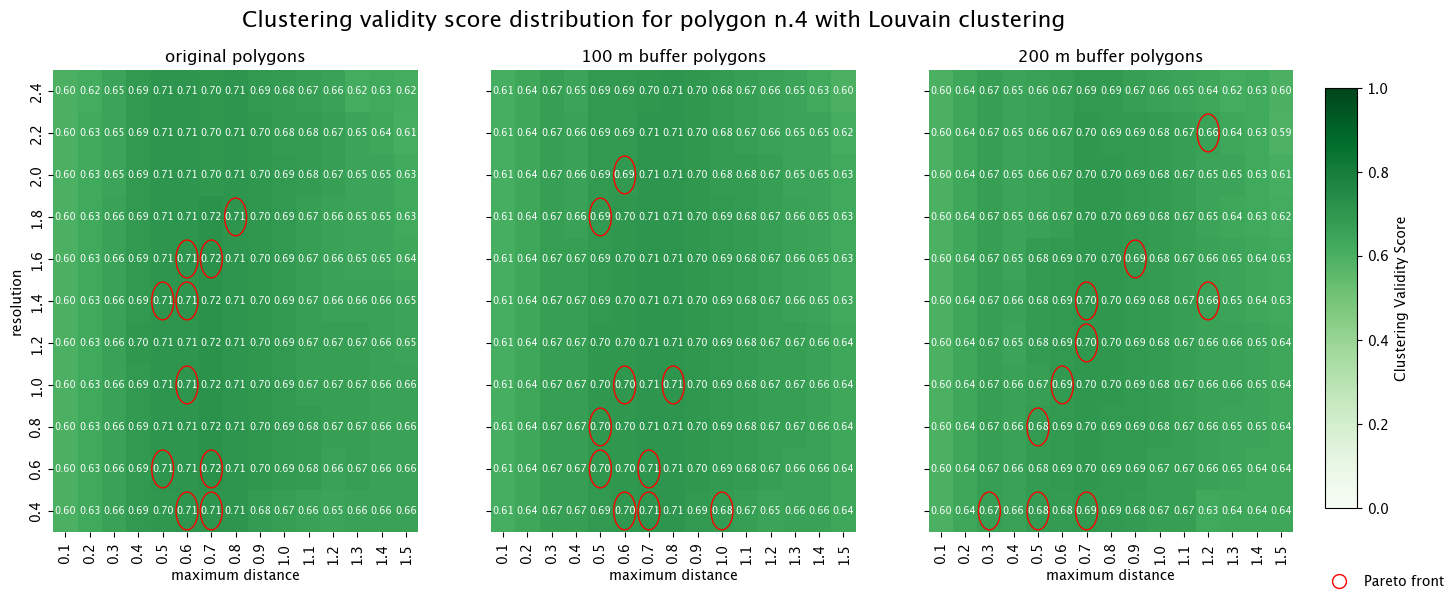

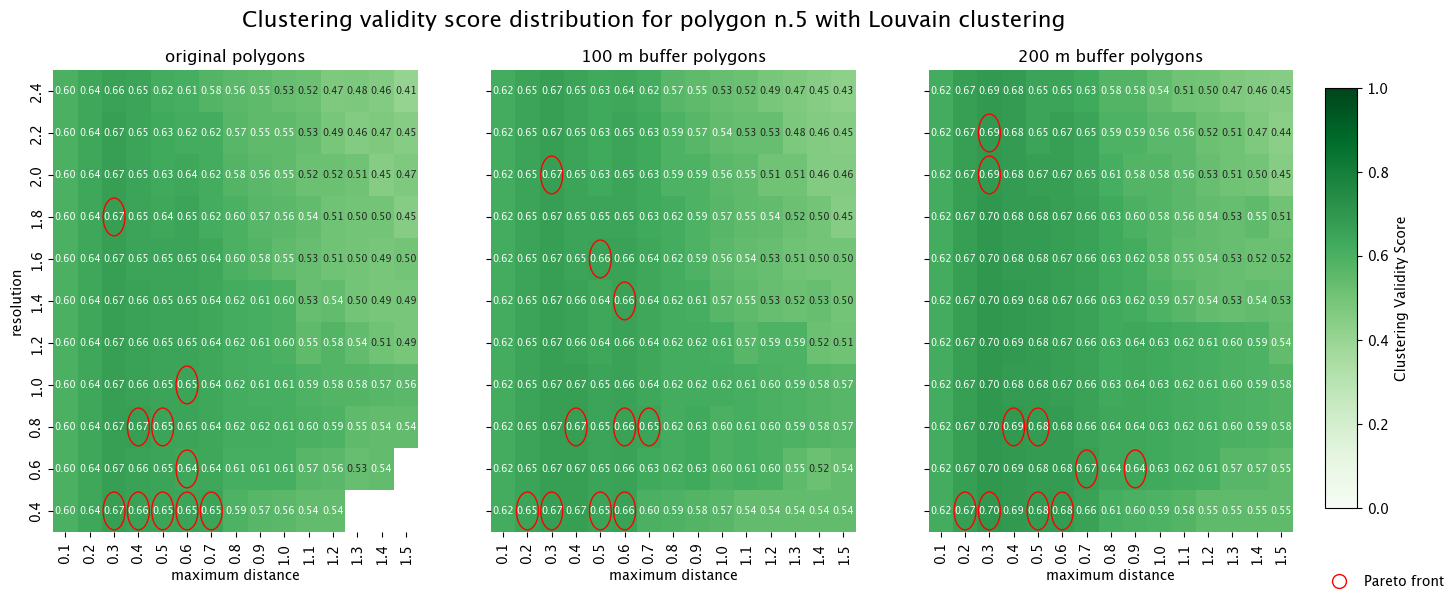

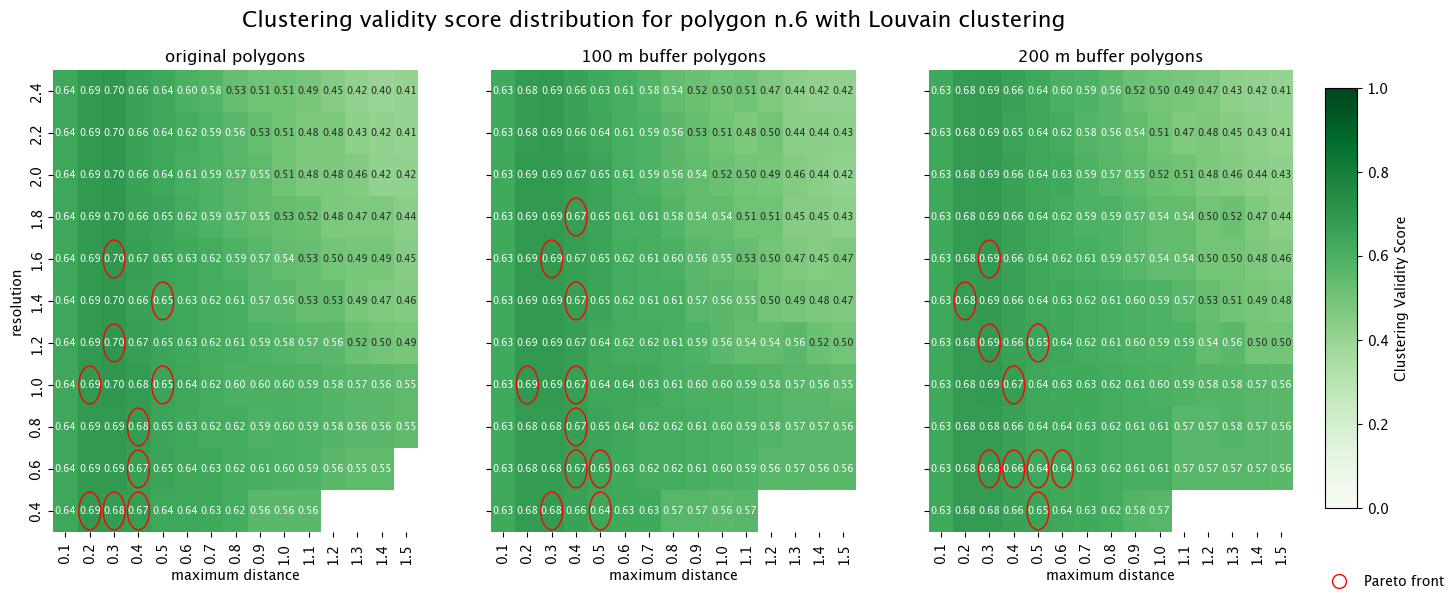

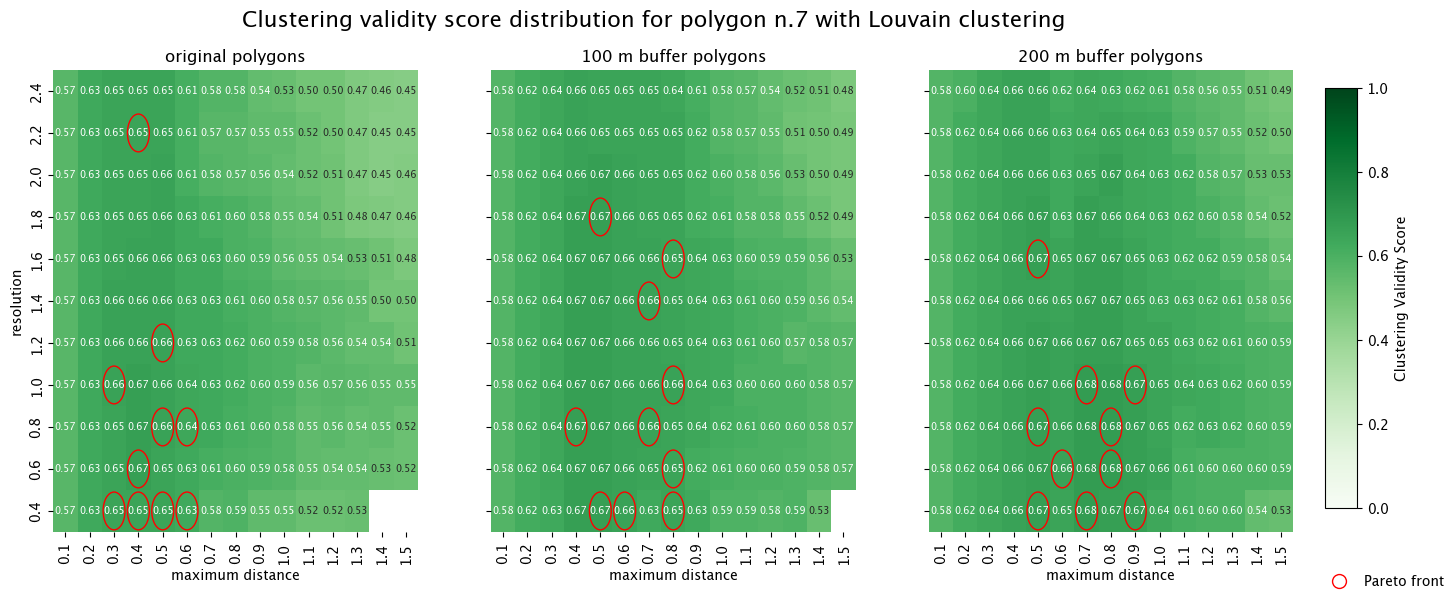

Stored the Clustering Validity Score heatmap with Pareto points highlighted.


In [24]:
cvs_heatmap = []

for pol in sorted(data.polygon_id.unique()):
    
    all_eps = np.arange(0.1, 1.3, 0.1)
    
    # obtain subsets
    res_original = data_original[data_original['polygon_id'] == pol].dropna(subset=['cvs'])
    res_buffer100 = data_buffer100[data_buffer100['polygon_id'] == pol].dropna(subset=['cvs'])
    res_buffer200 = data_buffer200[data_buffer200['polygon_id'] == pol].dropna(subset=['cvs'])
    
    # get pareto subset for this polygon
    pareto_pol = pareto_complete[pareto_complete['polygon_id'] == pol]

    # pivot and reindex
    original_pivot = res_original.pivot(index='res', columns='dist', values='cvs').reindex(index=resolution_parameter, columns=threshold_parameter)
    buffer100_pivot = res_buffer100.pivot(index='res', columns='dist', values='cvs').reindex(index=resolution_parameter, columns=threshold_parameter)
    buffer200_pivot = res_buffer200.pivot(index='res', columns='dist', values='cvs').reindex(index=resolution_parameter, columns=threshold_parameter)
    
    # annotations formatting 
    original_annots = original_pivot.stack().map(cleanup_format).unstack().reindex(index=original_pivot.index, columns=original_pivot.columns).fillna('')
    buffer100_annots = buffer100_pivot.stack().map(cleanup_format).unstack().reindex(index=buffer100_pivot.index, columns=buffer100_pivot.columns).fillna('')
    buffer200_annots = buffer200_pivot.stack().map(cleanup_format).unstack().reindex(index=buffer200_pivot.index, columns=buffer200_pivot.columns).fillna('')
    
    fig, axes = plt.subplots(1, 3, figsize=(16, 6), sharey=True)
    
    vmin, vmax = 0.0, 1.0
             
    # now call the helper for each dataset
    plot_heatmap_with_pareto(axes[0], original_pivot, original_annots,
                             "original polygons",
                             pareto_pol[pareto_pol.buffer=='original'])

    plot_heatmap_with_pareto(axes[1], buffer100_pivot, buffer100_annots,
                             "100 m buffer polygons",
                             pareto_pol[pareto_pol.buffer=='buffer_100'])

    plot_heatmap_with_pareto(axes[2], buffer200_pivot, buffer200_annots,
                             "200 m buffer polygons",
                             pareto_pol[pareto_pol.buffer=='buffer_200'])

    axes[0].set_ylabel("resolution")
    axes[1].set_ylabel("")
    axes[2].set_ylabel("")
    
    
    # shared colorbar
    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
    cmap = plt.get_cmap('Greens')
    norm = colors.Normalize(vmin=vmin, vmax=vmax)
    cbar = fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), cax=cbar_ax)
    cbar.set_label('Clustering Validity Score')
    
    legend_circle = Line2D([0], [0], marker='o', color='w', label='Pareto front',
                       markerfacecolor='none', markeredgecolor='red', markersize=10, markeredgewidth=1)
    fig.legend(handles=[legend_circle], loc='lower right', frameon=False, ncol=1)
    
    plt.subplots_adjust(top=0.88, right=0.9)
    plt.suptitle(f"Clustering validity score distribution for polygon n.{pol} with Louvain clustering", fontsize=16)
    plt.show()
        
    # save figure to buffer and collect as PIL Image
    buf = io.BytesIO()
    fig.savefig(buf, format='png', bbox_inches='tight')
    buf.seek(0)
    img = Image.open(buf)
    cvs_heatmap.append(img)
    plt.close(fig)

# merge all the results together
total_height = sum(img.height for img in cvs_heatmap)
max_width = max(img.width for img in cvs_heatmap)

merged_image = Image.new('RGB', (max_width, total_height), (255, 255, 255))
y_offset = 0
for img in cvs_heatmap:
    merged_image.paste(img, (0, y_offset))
    y_offset += img.height

merged_image.save("images/louvain_cvs_pareto.png")

print("Stored the Clustering Validity Score heatmap with Pareto points highlighted.")
